<a href="https://colab.research.google.com/github/antomys/UniversityStuff/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22SVM%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Out of box SVM Classifier

First let's make all nesessary imports to implement our own SVM from scratch

In [1]:
import pandas as pd
from random import seed
from random import randrange
from math import exp
from math import log
from math import floor

Now we need a function to split data into train and test fractions

In [2]:

#Function to split data into train and test
def cross_val_split(data_X,data_Y,test_size,seed_val):
	data_x = data_X.tolist()
	data_y = data_Y.tolist()
	seed(seed_val)
	train_size = floor((1 - test_size)*len(data_x))
	train_x = []
	train_y = []
	while(len(train_x)<train_size):
		index = randrange(len(data_x))
		train_x.append(data_x.pop(index))
		train_y.append(data_y.pop(index))
	return train_x,train_y,data_x,data_y

After this we need a function to return columnwise max-min statistics for scaling and function to scale the features

In [3]:

#Function to return columnwise max-min statistics for scaling
def statistics(x):
	cols = list(zip(*x))
	stats = []
	for e in cols:
		stats.append([min(e),max(e)])
	return stats

#Function to scale the features
def scale(x, stat):
	for row in x:
		for i in range(len(row)):
			row[i] = (row[i] - stat[i][0])/(stat[i][1] - stat[i][0])

As out dataset has different classes, we need a function to convert them into different columns. A.K.A OneVsAll 

In [4]:
#Function to convert different classes into different columns to implement one v/s all
def one_vs_all_cols(s):
	m = list(set(s))
	m.sort()
	for i in range(len(s)):
		new = [0]*len(m)
		new[m.index(s[i])] = 1
		s[i] = new
	return m


Function to compute Theta transpose x Feature Vector

In [5]:
#Function to compute Theta transpose x Feature Vector
def ThetaTX(Q,X):
	det = 0.0
	for i in range(len(Q)):
		det += X[i]*Q[i]
	return det

Function to compute cost for negative and positive classses (classs = 0 & classs = 1)

In [6]:
#Function to compute cost for negative class (classs = 0)
def LinearSVM_cost0(z):
	if(z < -1): #Ensuring margin
		return 0
	return z + 1

#Function to compute cost for positive class (classs = 1)
def LinearSVM_cost1(z):
	if(z > 1): #Ensuring margin
		return 0
	return -z + 1

Calculating cost and sigmoid

In [7]:
#function to calculate sigmoid
def sigmoid(z):
	return 1.0/(1.0 + exp(-z))

#Function to calculate SVM cost
def cost(theta,c,x,y):
	cost = 0.0
	for i in range(len(x)):
		z = ThetaTX(theta[c], x[i])
		cost += y[i]*LinearSVM_cost1(z) + (1 - y[i])*LinearSVM_cost0(z)
		#cost += -1*(y[i]*log(sigmoid(z)) + (1 - y[i])*log(1 - sigmoid(z)))
	return cost

Time to perform Gradient Descent on the weights/parameters

In [8]:
#Function to perform Gradient Descent on the weights/parameters
def gradDescent(theta,c,x,y,learning_rate):
	oldTheta = theta[c]
	for Q in range(len(theta[c])):
		derivative_sum = 0 
		for i in range(len(x)):
			derivative_sum += (sigmoid(ThetaTX(oldTheta,x[i])) - y[i])*x[i][Q]
		theta[c][Q] -= learning_rate*derivative_sum

In [9]:
#Function to return predictions using trained weights
def predict(data,theta):
	predictions = []
	count = 1
	for row in data:
		hypothesis = []
		multiclass_ans = [0]*len(theta)
		for c in range(len(theta)):
			z = ThetaTX(row,theta[c])
			hypothesis.append(sigmoid(z))
		index = hypothesis.index(max(hypothesis))
		multiclass_ans[index] = 1
		predictions.append(multiclass_ans)
		count+=1
	return predictions

#Function to return accuracy
def accuracy(predicted, actual):
	n = len(predicted)
	correct = 0
	for i in range(n):
		if(predicted[i]==actual[i]):
			correct+=1
	return correct/n

In [10]:
#Function to perform cross validation
def cross_validation(x,y,test_data_size,validations,learning_rate,epoch):
	print("No. of validation checks to be performed: ",validations)
	print("No. of Iterations per validation: ",epoch)
	accuracies = []
	for valid in range(validations):
		print("\nRunning Validation",valid+1)
		x_train, y_train, x_test, y_test = cross_val_split(x,y,test_data_size,valid+1)
		#Converting y_train to classwise columns with 0/1 values
		classes = []
		for i in range(len(label_map)):
			classes.append([row[i] for row in y_train])
		#Initialising Theta (Weights)
		theta = [[0]*len(x_train[0]) for _ in range(len(classes))]
		#Training the model
		for i in range(epoch):
			for class_type in range(len(classes)):
				gradDescent(theta,class_type,x_train,classes[class_type],learning_rate)
			if(i%(epoch/10)==0):
				print("Processed", i*100/epoch,"%")
		print("Completed")
		#Predicting using test data
		y_pred = predict(x_test,theta)
		#Calculating accuracy
		accuracies.append(accuracy(y_pred,y_test))
		print("Validation",valid+1,"accuracy score: ",accuracies[valid])
	return sum(accuracies)/len(accuracies), y_pred

# Dataset work

Importing dataset and proceding to training
Dataset: Johnson, B., Tateishi, R., Xie, Z., 2012. Using geographically-weighted variables for image classification. Remote Sensing Letters, 3 (6), 491-499.

In this study, geographically weighted variables calculated for two tree species, Cryptomeria japonica (Sugi) and Chamaecyparis obtusa (Hinoki), were used in addition to spectral information to classify the two species and one mixed forest class. Spectral values (digital numbers for each band) of 'Sugi' and 'Hinoki' train-ing samples were used to predict the spectral values for the two species at other locations using the inverse distance weighting (IDW) interpolation method. Next, the similarity between each pixel's spectral values and their IDW predicted values was calculated for both of the tree species. The similarity measures are considered to be geographically weighted because nearer training samples have more of an impact on their calculation. The use of geographically weighted variables resulted in an increase in overall accuracy from 82.2% to 85.9% and an increase in the kappa coefficient from 0.740 to 0.795 for a support vector machine classification.

In [11]:
#Dataset url to be imported
print("SVM\n")
url = "https://raw.githubusercontent.com/antomys/UniversityStuff/main/ML/SVM/dataset.csv"
dataset = pd.read_csv(url)
data = dataset.values
report = []
#Assigning x and y - features and classes
x = data[:,:26]
y = data[:,27]
#Feature Scaling by using column wise max, min stats
stats = statistics(x)
scale(x,stats)
#Converting different labels to columns

#label_map can be used later to retrieve the predicted class label in the original form (string format)
label_map = one_vs_all_cols(y)

#Splitting dataset into training and testing data
test_data_size = 0.2
learning_rate = 0.01
epoch = 500
validations = 5
final_score,y_pred = cross_validation(x,y,test_data_size,validations,learning_rate,epoch)


SVM

No. of validation checks to be performed:  5
No. of Iterations per validation:  500

Running Validation 1
Processed 0.0 %
Processed 10.0 %
Processed 20.0 %
Processed 30.0 %
Processed 40.0 %
Processed 50.0 %
Processed 60.0 %
Processed 70.0 %
Processed 80.0 %
Processed 90.0 %
Completed
Validation 1 accuracy score:  0.9142857142857143

Running Validation 2
Processed 0.0 %
Processed 10.0 %
Processed 20.0 %
Processed 30.0 %
Processed 40.0 %
Processed 50.0 %
Processed 60.0 %
Processed 70.0 %
Processed 80.0 %
Processed 90.0 %
Completed
Validation 2 accuracy score:  0.8857142857142857

Running Validation 3
Processed 0.0 %
Processed 10.0 %
Processed 20.0 %
Processed 30.0 %
Processed 40.0 %
Processed 50.0 %
Processed 60.0 %
Processed 70.0 %
Processed 80.0 %
Processed 90.0 %
Completed
Validation 3 accuracy score:  0.8857142857142857

Running Validation 4
Processed 0.0 %
Processed 10.0 %
Processed 20.0 %
Processed 30.0 %
Processed 40.0 %
Processed 50.0 %
Processed 60.0 %
Processed 70.0 %
Proc

Reporting:

In [12]:
#Printing Final Stats
print("\nReport")
print("Model used: ","Linear SVM using Gradient Descent")
print("Learning rate: ", learning_rate)
print("No. of iterations: ",epoch)
print("No. of features: ", len(x[0]))
print("Training data size: ", floor(len(x)*(1 - test_data_size)))
print("Test data size: ", len(x) - floor(len(x)*(1 - test_data_size)))
print("No. of validation tests performed: ", validations)
print("Accuracy: ",final_score*100,"%")

report.append(final_score*100)


Report
Model used:  Linear SVM using Gradient Descent
Learning rate:  0.01
No. of iterations:  500
No. of features:  26
Training data size:  417
Test data size:  105
No. of validation tests performed:  5
Accuracy:  88.57142857142858 %


# InBox SVM

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_validation, Y_train, Y_validation = train_test_split(x, y, test_size=0.2, 
random_state=42)

In [14]:
dataset.loc[6]
dataset.describe()

,31,26,47,90,52,94,53,22,48,86.08,25.75,51.01,13.74,-25.95,-31.4,27.52,8.09,8.28,-24.26,-1.74,-4.66,-28.43,-0.98,-5.94,-24.63,-2.51,-5.83
count,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,59.942529,39.406130,62.333333,98.172414,58.350575,99.758621,87.724138,27.885057,59.749042,53.844368,11.540613,34.027529,-0.302989,-33.025172,-39.510402,-11.069042,1.831034,-4.218180,-20.009176,-1.054885,-4.367644,-21.398123,-0.977510,-4.617280,-18.926322,-1.650556,-4.198257
std,12.291741,15.934601,15.938823,12.888603,11.344107,10.158210,16.343968,8.080343,9.285835,12.688999,16.315420,16.746116,13.220940,11.283716,9.954781,16.406092,8.162585,9.299518,3.805936,1.376635,2.054942,4.896489,0.495683,1.352154,4.143893,1.371979,1.518128
min,31.000000,23.000000,47.000000,54.000000,43.000000,83.000000,42.000000,19.000000,45.000000,4.950000,-112.600000,-106.120000,-77.010000,-74.560000,-77.170000,-62.740000,-54.740000,-58.280000,-32.950000,-8.800000,-11.210000,-40.370000,-3.270000,-8.730000,-34.140000,-8.870000,-10.830000
25%,52.000000,28.000000,52.000000,90.000000,50.000000,93.000000,76.000000,24.000000,55.000000,45.557500,3.175000,28.045000,-8.647500,-38.495000,-43.797500,-21.857500,2.532500,-5.027500,-22.490000,-1.797500,-5.632500,-24.110000,-1.210000,-5.517500,-21.810000,-2.360000,-4.940000
50%,58.000000,32.000000,56.000000,96.000000,55.000000,97.000000,88.000000,25.000000,57.000000,55.375000,18.825000,39.790000,1.720000,-28.970000,-36.520000,-11.550000,4.300000,-1.890000,-19.985000,-1.025000,-4.460000,-20.815000,-0.980000,-4.635000,-19.045000,-1.580000,-4.130000
75%,67.000000,48.000000,67.000000,107.000000,64.000000,104.000000,99.000000,27.000000,60.000000,62.325000,22.670000,44.592500,8.850000,-24.660000,-32.422500,0.377500,5.680000,0.907500,-18.075000,-0.300000,-2.835000,-18.732500,-0.730000,-3.805000,-16.605000,-0.912500,-3.242500
max,107.000000,160.000000,196.000000,172.000000,100.000000,138.000000,139.000000,84.000000,114.000000,85.350000,29.900000,57.550000,40.820000,-18.400000,-23.550000,34.660000,10.830000,9.580000,5.130000,12.460000,7.370000,1.880000,3.440000,3.940000,3.670000,8.840000,7.790000


Plot histograms for each variable

Next, we use a scatterplot matrix in order to decide whether a SVM will be a good classifier for our data, or we have to use more complicated methods.

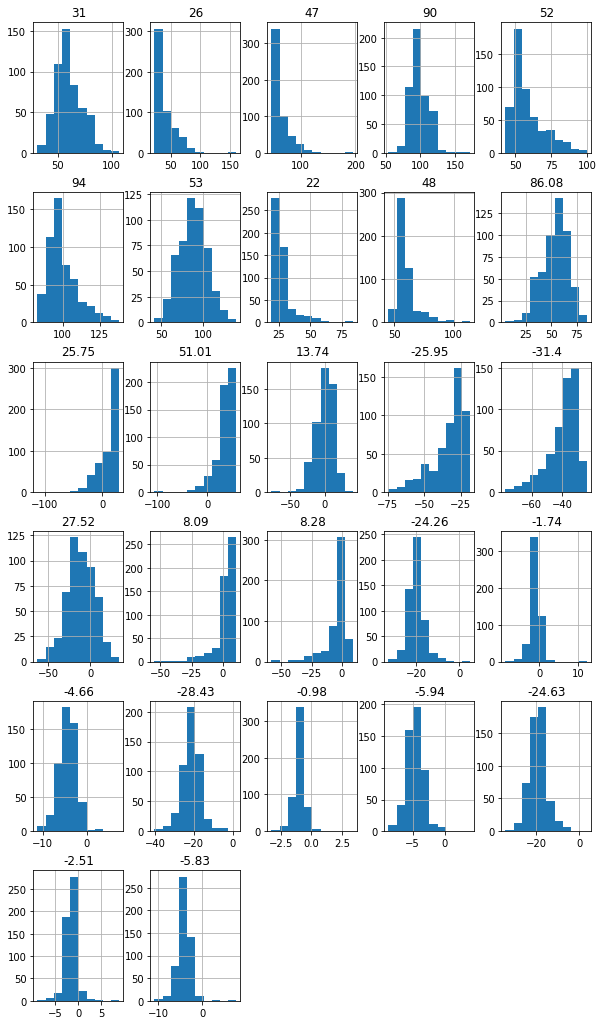

In [15]:
import matplotlib.pyplot as plt
dataset.hist(figsize = (10, 18))
plt.show()

RESULT:

There is a strong relationship between -24.26 and -1.74. 26 and 47).
Some other cells have a good linear relationship.
However, no easy way to classify the relationships among the classifications

,31,26,47,90,52,94,53,22,48,86.08,25.75,51.01,13.74,-25.95,-31.4,27.52,8.09,8.28,-24.26,-1.74,-4.66,-28.43,-0.98,-5.94,-24.63,-2.51,-5.83
31,1.000000,0.144320,0.207010,0.681817,-0.012629,0.082390,0.496994,0.174032,0.337408,-0.964927,-0.153981,-0.221705,-0.660920,0.010420,-0.090410,-0.473813,-0.169765,-0.334146,0.062428,0.020587,0.048697,0.103313,0.013699,0.030169,0.066533,0.066021,0.057704
26,0.144320,1.000000,0.976863,0.047004,0.822907,0.742822,0.335299,0.663726,0.618161,-0.168376,-0.992689,-0.953667,-0.084854,-0.826873,-0.761616,-0.349490,-0.654045,-0.613591,0.045504,0.016080,0.002706,0.112713,0.050048,0.055560,0.097856,0.073755,0.065278
47,0.207010,0.976863,1.000000,0.062245,0.774148,0.703040,0.280823,0.660877,0.621167,-0.232396,-0.973109,-0.981188,-0.102515,-0.779176,-0.725257,-0.295052,-0.651865,-0.617972,0.044735,0.037079,0.008972,0.121189,0.047820,0.058115,0.101595,0.092532,0.084311
90,0.681817,0.047004,0.062245,1.000000,-0.050089,0.212451,0.520786,0.084987,0.227244,-0.608342,-0.028905,-0.029373,-0.950073,0.053966,-0.202597,-0.492942,-0.087218,-0.224709,0.045486,0.002068,0.095033,0.011853,0.058869,0.085288,0.017849,-0.018790,-0.021923
52,-0.012629,0.822907,0.774148,-0.050089,1.000000,0.920156,0.287539,0.741357,0.692741,0.026708,-0.790162,-0.712876,0.037100,-0.998620,-0.920720,-0.284313,-0.730743,-0.682162,0.007198,0.048580,0.057212,0.056433,0.113709,0.094054,0.014458,0.014203,-0.007738
94,0.082390,0.742822,0.703040,0.212451,0.920156,1.000000,0.326468,0.756455,0.751667,-0.031972,-0.693829,-0.609763,-0.213320,-0.914061,-0.987396,-0.315902,-0.752160,-0.742791,-0.017571,0.054513,0.109376,0.023612,0.153144,0.147557,-0.005687,0.006247,-0.022462
53,0.496994,0.335299,0.280823,0.520786,0.287539,0.326468,1.000000,0.172448,0.334420,-0.477589,-0.327808,-0.273612,-0.461709,-0.284662,-0.319749,-0.979216,-0.154186,-0.316056,0.087203,-0.060231,-0.028069,0.061574,0.035237,-0.013230,0.042079,-0.045486,-0.056832
22,0.174032,0.663726,0.660877,0.084987,0.741357,0.756455,0.172448,1.000000,0.949936,-0.180258,-0.648464,-0.622253,-0.119935,-0.736242,-0.749992,-0.189619,-0.993470,-0.945371,0.063487,0.049390,0.072307,0.092674,0.121691,0.095711,0.100765,0.082019,0.055775
48,0.337408,0.618161,0.621167,0.227244,0.692741,0.751667,0.334420,0.949936,1.000000,-0.333705,-0.602011,-0.581108,-0.251489,-0.685747,-0.739515,-0.347618,-0.943743,-0.993852,0.084006,0.059258,0.093897,0.096435,0.131788,0.100742,0.106994,0.080279,0.053411
86.08,-0.964927,-0.168376,-0.232396,-0.608342,0.026708,-0.031972,-0.477589,-0.180258,-0.333705,1.000000,0.195571,0.280475,0.635230,-0.021173,0.056274,0.499549,0.177291,0.338306,-0.227550,-0.052321,-0.089282,-0.222526,-0.055400,-0.095158,-0.231700,-0.137781,-0.154838


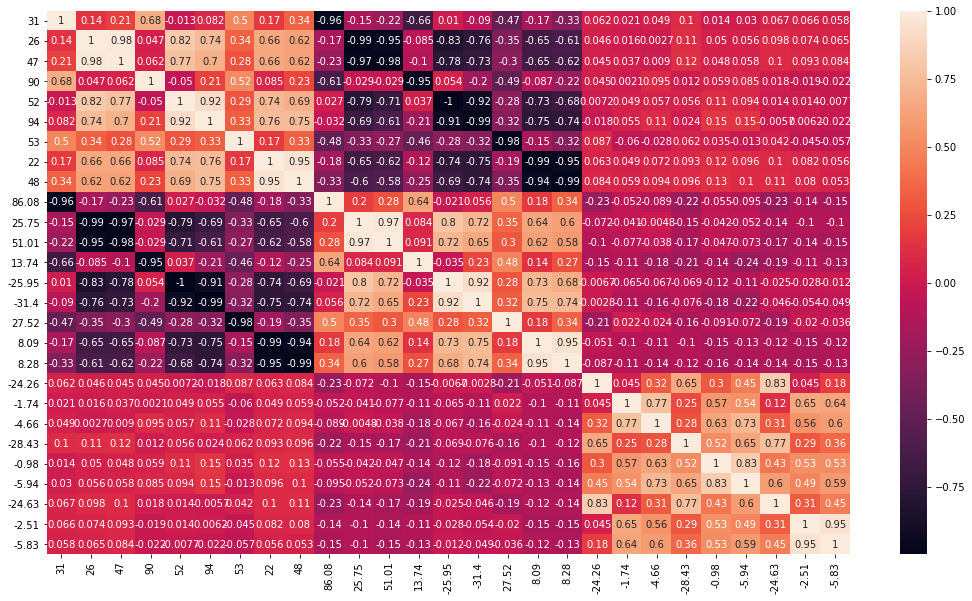

In [16]:
import seaborn as sns
corr = dataset.corr()
fig, ax = plt.subplots(figsize=(18,10)) 
sns.heatmap(corr,annot=True)
corr

1. The first step that we need to perform is to split our dataset into X and Y datasets for training. We won't train all of the available data, as we need to save some for our validation step. This will help us to determine how well these algorithms can generalize to new data, and not just how well they know the training data.

2. Our X data will contain all of the variables, except for the class column, and our Y data is going to be the class column, which is the classification of whether a tumor is malignant or benign.

3. Next, we will use the train_test_split function, and we will then split our data into y_train, y_test, X_train and X_test, respectively.

4. In the same line, we will add train_test_split and X, y, test_size. About 20% of our data is fairly standard, so we will make the test size 0.2 to test the data.

In [17]:
import numpy as np
data = dataset.values
#Assigning x and y - features and classes
X = data[:,:26]
y = data[:,27]

1. Next, we will add a seed, which makes the data reproducible. We will start with a random seend, which will change the results a little bit every time.

  > If a seed is defined and we stay consistent, we should be able to reproduce our results.


2. In scoring, we will add accuracy.

In [22]:
def setValues(size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size)

  print('X_train shape: ', X_train.shape)
  print('y_train shape: ', y_train.shape)
  print('X_test shape: ', X_test.shape)
  print('y_test shape: ', y_test.shape)

  seed = 8
  scoring = 'accuracy'

  return  X_train, X_test, y_train, y_test

In [23]:
X_train, X_test, y_train, y_test = setValues(0.2)

X_train shape:  (417, 26)
y_train shape:  (417,)
X_test shape:  (105, 26)
y_test shape:  (105,)


In [27]:
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
scoring = 'accuracy'
models = []
results = []
names = []
models.append(('Naive', GaussianNB()))
models.append(('SVM', SVC(kernel='linear')))
# Evaluate each model in turn

for name, model in models:
  kfold = model_selection.KFold(n_splits=10, random_state = seed)
  cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  if name =='SVM':
    report.append(cv_results.mean())
  print(msg)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Naive: 0.860859 (0.050566)
SVM: 0.882753 (0.052370)


**Result:** In some cases Naive Bayes narrowly beats SVM

In [31]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
for name, model in models:
  model.fit(X_train, y_train)
  predictions = model.predict(X_test)
  print(name)
  print(accuracy_score(y_test, predictions))
  print(classification_report(y_test, predictions))
  print(confusion_matrix(y_test,predictions))
print('Out of box SVM: ', report[0], '%')
print('In house SVM: ', report[1]*100, '%')

Naive
0.8952380952380953
              precision    recall  f1-score   support

           d       0.97      0.80      0.88        35
           h       0.90      0.95      0.93        20
           o       0.86      0.95      0.90        20
           s       0.85      0.93      0.89        30

    accuracy                           0.90       105
   macro avg       0.90      0.91      0.90       105
weighted avg       0.90      0.90      0.89       105

[[28  0  3  4]
 [ 0 19  0  1]
 [ 1  0 19  0]
 [ 0  2  0 28]]
SVM
0.9333333333333333
              precision    recall  f1-score   support

           d       1.00      0.89      0.94        35
           h       0.95      0.90      0.92        20
           o       0.91      1.00      0.95        20
           s       0.88      0.97      0.92        30

    accuracy                           0.93       105
   macro avg       0.93      0.94      0.93       105
weighted avg       0.94      0.93      0.93       105

[[31  0  2  2]
 [ 0 1

Out-of-box SVM achieved 88.5%
In-of-box SVM achieved 87.04%

The result above also shows some other measures, such as precision, recall and f1-score.

The precision is a measure of false positives (ratio of correctly predicted positive observations to the total predicted positive observations.

We will now go back and make predictions on our validation set, because the numbers shown in the preceding screenshot just represent the accuracy of our training data. If we split up the datasets differently, we'll get the following results:

In [32]:
X_train, X_test, y_train, y_test = setValues(0.25)
models = []
models.append(('Naive', GaussianNB()))
models.append(('SVM', SVC(kernel='linear')))
# Evaluate each model in turn

for name, model in models:
  kfold = model_selection.KFold(n_splits=10, random_state = seed)
  cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg)
  if name =='SVM':
    report.append(cv_results.mean())
  

X_train shape:  (391, 26)
y_train shape:  (391,)
X_test shape:  (131, 26)
y_test shape:  (131,)
Naive: 0.869679 (0.056330)


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


SVM: 0.887692 (0.040539)


Now let's build ROC Curve for each class given and see:

In [35]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import sklearn.metrics as metrics
y = label_binarize(y, classes=['d','s','o','h'])
n_classes = 4
clf = OneVsRestClassifier(SVC(kernel='linear', C=1, decision_function_shape='ovo'))
y_score = clf.fit(X_train, y_train).decision_function(X_test)

y_test_dummies = pd.get_dummies(y_test, drop_first=False).values
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_dummies[:, i], y_score[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

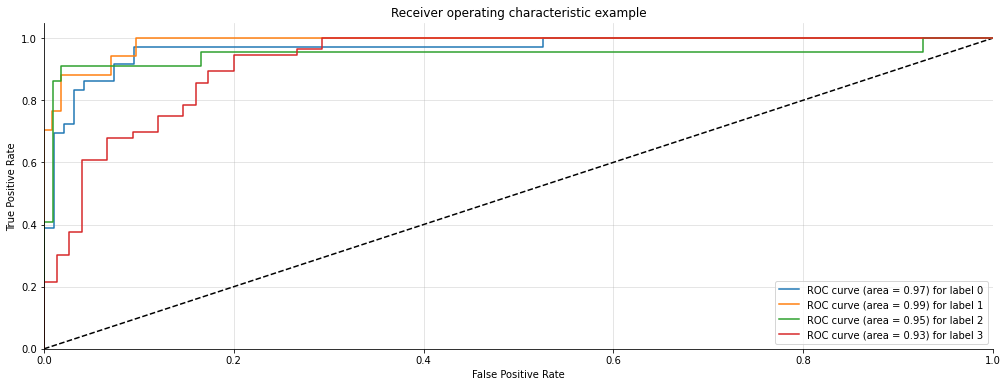

In [36]:
# Plot of a ROC curve for a specific class
figsize=(17, 6)
fig, ax = plt.subplots(figsize=figsize)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
for i in range(n_classes):
  ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %i' % (roc_auc[i], i))
ax.legend(loc="best")
ax.grid(alpha=.4)
sns.despine()
plt.show()